In [1]:
import re
import pandas as pd
import seaborn as sns #visualization library
import missingno as msno #Tracks missing values
import numpy as np
import matplotlib.pyplot as plt #visualization library
import datetime
import pickle #dumps the model in pickle format

import sklearn
from sklearn.impute import SimpleImputer #Imputes missing values with strategy modes like mean,median,mode
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.feature_selection import SelectKBest,chi2,f_regression,SelectPercentile
from sklearn.preprocessing import StandardScaler,MinMaxScaler #Scaling the data

pd.options.mode.chained_assignment = None
now = datetime.datetime.now()

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ravirajdasari/datasets/main/Car%20details%20v3.csv')

In [3]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


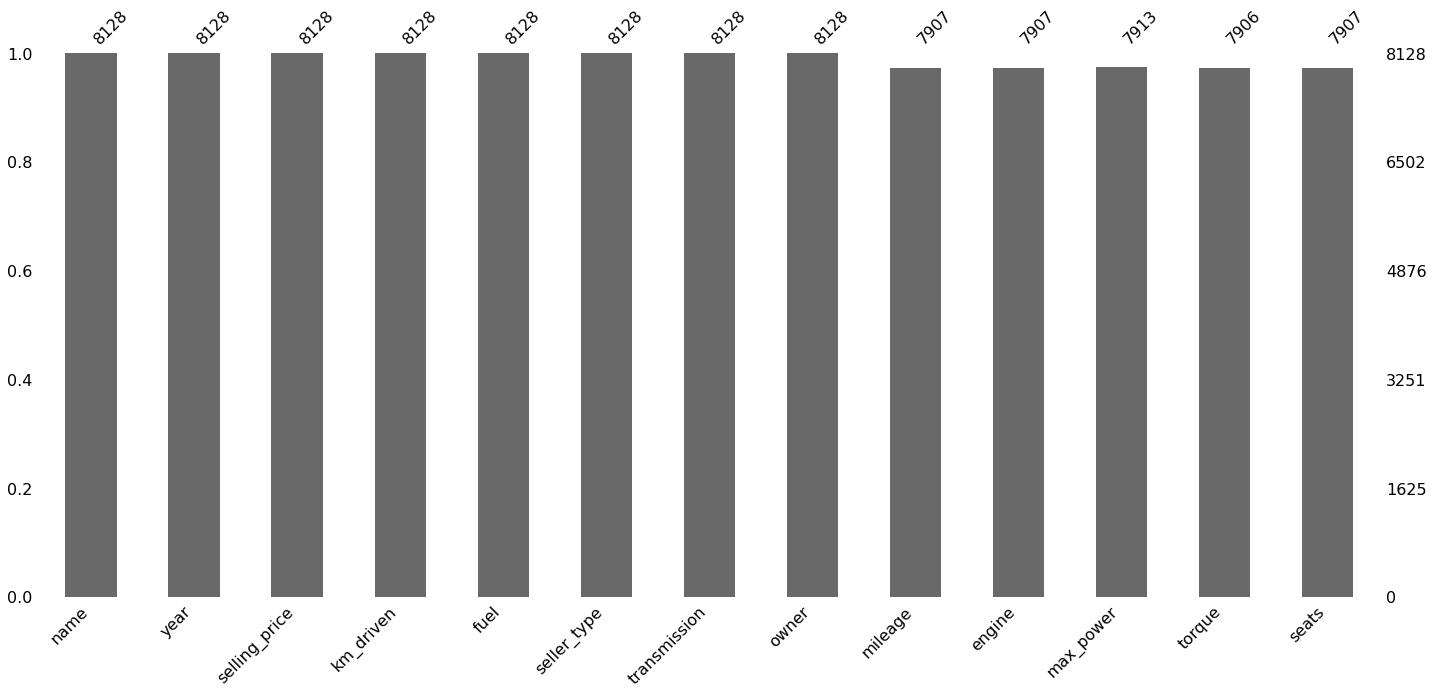

In [4]:
msno.bar(df)

In [5]:
df['age'] = now.year - df['year']

In [6]:
#df['brand'] = df['name'].apply(lambda x: x.split()[0])

In [7]:
df['mileage'] = df['mileage'].apply(lambda x: float(re.findall(r'\d*.*\d',x)[0]) if not pd.isnull(x) else np.nan)

In [8]:
df['engine'] = df['engine'].apply(lambda x: float(re.findall(r'\d*.*\d',x)[0]) if not pd.isnull(x) else np.nan)

In [9]:
def get_max_power(item):
    if not pd.isnull(item):
        try:
            item = float(re.findall(r'\d*.*\d',item)[0])
        except:
            item = np.nan
    else:
        item = np.nan
    return item
df['max_power'] = df['max_power'].apply(get_max_power)

In [10]:
columns_to_be_dropped = ['name','year','torque']
df.drop(columns_to_be_dropped,axis=1,inplace=True)

In [11]:
categ_cols = ['fuel','seller_type','transmission','owner']

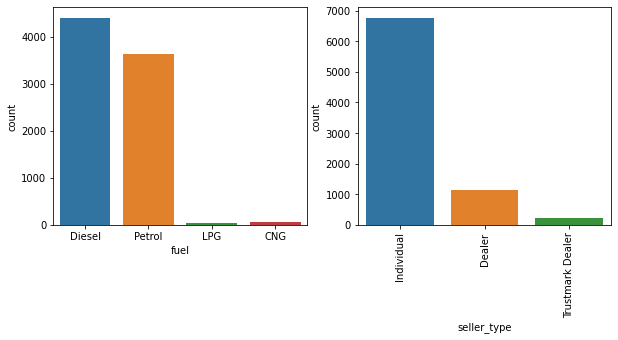

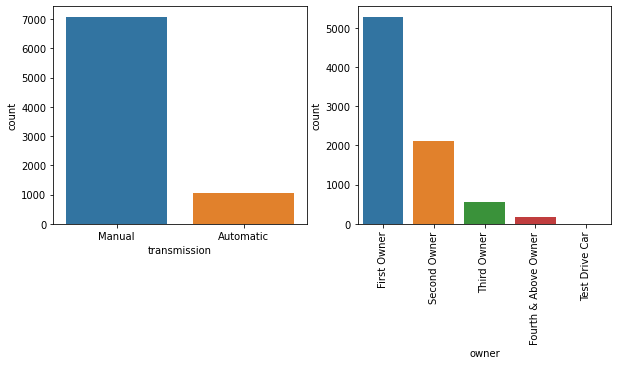

In [12]:
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    sns.countplot(x=categ_cols[i], data=df)
    i += 1
    plt.subplot(1,2,2)
    sns.countplot(x=categ_cols[i], data=df)
    i += 1
    plt.xticks(rotation=90)
    plt.show()

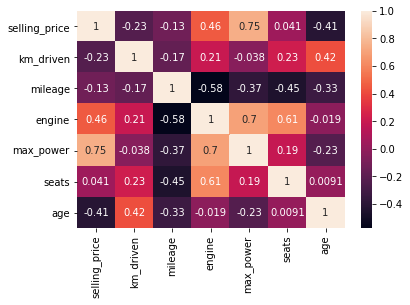

In [13]:
sns.heatmap(df.corr(),annot=True)

In [14]:
df = pd.get_dummies(df,columns = categ_cols)

In [15]:
#Handle missing values with sklearn
columns_to_impute = ['mileage','engine','max_power','seats']
imputer = SimpleImputer(strategy='mean')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [16]:
df.columns

Index(['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats',
       'age', 'fuel_CNG', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Dealer', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'transmission_Automatic',
       'transmission_Manual', 'owner_First Owner',
       'owner_Fourth & Above Owner', 'owner_Second Owner',
       'owner_Test Drive Car', 'owner_Third Owner'],
      dtype='object')

In [17]:
features = df.drop('selling_price',axis=1)
target = df['selling_price']

In [18]:
features

,km_driven,mileage,engine,max_power,seats,age,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,145500,23.40,1248.0,74.00,5.0,7,0,1,0,0,0,1,0,0,1,1,0,0,0,0
1,120000,21.14,1498.0,103.52,5.0,7,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,140000,17.70,1497.0,78.00,5.0,15,0,0,0,1,0,1,0,0,1,0,0,0,0,1
3,127000,23.00,1396.0,90.00,5.0,11,0,1,0,0,0,1,0,0,1,1,0,0,0,0
4,120000,16.10,1298.0,88.20,5.0,14,0,0,0,1,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,110000,18.50,1197.0,82.85,5.0,8,0,0,0,1,0,1,0,0,1,1,0,0,0,0
8124,119000,16.80,1493.0,110.00,5.0,14,0,1,0,0,0,1,0,0,1,0,1,0,0,0
8125,120000,19.30,1248.0,73.90,5.0,12,0,1,0,0,0,1,0,0,1,1,0,0,0,0
8126,25000,23.57,1396.0,70.00,5.0,8,0,1,0,0,0,1,0,0,1,1,0,0,0,0


In [19]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

In [20]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [21]:
y_pred = rfr.predict(X_test)

In [22]:
#r2_Score
r2_score(y_test,y_pred)

0.972324174172547

In [23]:
#Root mean squared error
np.sqrt(mean_squared_error(y_test,y_pred))

134688.8013356906

In [24]:
cross_val_mean=cross_val_score(rfr,X_train,y_train,cv=5,scoring='r2').mean()

In [25]:
print(cross_val_mean)

0.9627376633799388


<Figure size 1008x1152 with 0 Axes>

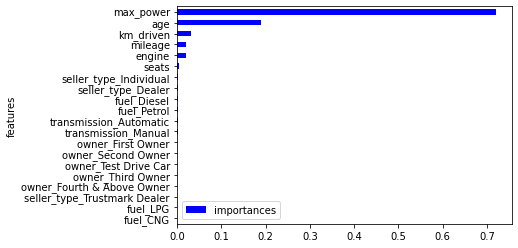

In [26]:
plt.figure(figsize=(14,16))
df3=pd.DataFrame({'features':X_train.columns,'importances':rfr.feature_importances_})
df3.sort_values('importances',inplace=True)
df3.plot(kind='barh',y='importances',x='features',color='b')

In [27]:
important_features = df3['features'].to_list()[-5:]

In [28]:
important_features

['engine', 'mileage', 'km_driven', 'age', 'max_power']

In [29]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train[important_features],y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
y_pred1 = gbr.predict(X_test[important_features])

In [31]:
r2_score(y_test,y_pred1)

0.9531774111471032

In [32]:
np.sqrt(mean_squared_error(y_test,y_pred1))

175189.83547152212

In [33]:
results = X_test[important_features]
results['Actual_SP'] = y_test
results['Predicted_SP'] = [int(i) for i in y_pred]
results.head()

,engine,mileage,km_driven,age,max_power,Actual_SP,Predicted_SP
1971,1493.0,12.8,110000,17,100.00,198000,162593
4664,2179.0,14.0,291977,7,138.10,500000,555079
5448,1248.0,23.2,70000,5,73.94,425000,426259
3333,1497.0,16.9,120000,15,100.00,150000,161309
2316,1248.0,22.9,69000,8,74.00,525000,377906


In [34]:
results

,engine,mileage,km_driven,age,max_power,Actual_SP,Predicted_SP
1971,1493.0,12.80,110000,17,100.00,198000,162593
4664,2179.0,14.00,291977,7,138.10,500000,555079
5448,1248.0,23.20,70000,5,73.94,425000,426259
3333,1497.0,16.90,120000,15,100.00,150000,161309
2316,1248.0,22.90,69000,8,74.00,525000,377906
...,...,...,...,...,...,...,...
1149,1995.0,16.78,8500,2,190.00,5500000,5500000
5002,1197.0,20.89,40000,4,81.80,370000,520169
6008,1197.0,18.90,54043,7,81.86,374000,425169
2283,1198.0,17.00,70000,3,108.50,575000,812950


In [35]:
list(gbr.get_params().keys())

['alpha',
 'ccp_alpha',
 'criterion',
 'init',
 'learning_rate',
 'loss',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_iter_no_change',
 'presort',
 'random_state',
 'subsample',
 'tol',
 'validation_fraction',
 'verbose',
 'warm_start']

In [36]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
#Trying Hyperparameter tuning to see if it gives better results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

gbc = GradientBoostingRegressor()

params = {
    'n_estimators':[450,500,550],
    'max_depth':[2,4,8],
    'learning_rate': [0.01, 0.1]
}
grid_gb = GridSearchCV(gbc,params,cv=5,n_jobs=2,verbose=2)
grid_gb.fit(X_train[important_features],y_train)

print_results(grid_gb)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  3.4min finished


BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}

0.916 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 450}
0.92 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
0.923 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 550}
0.954 (+/-0.023) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 450}
0.956 (+/-0.023) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
0.957 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 550}
0.965 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 450}
0.965 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500}
0.965 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 550}
0.956 (+/-0.022) for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 450}
0.956 (+/-0.022) for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
0.956 (+/-0.022) for {'lear

In [39]:
r2_score(y_test,grid_gb.predict(X_test[important_features]),y_test.ravel())

0.9659259001525576

In [40]:
#saves the model
pickle.dump(rfr, open('model.pkl', 'wb'))